<a href="https://colab.research.google.com/github/BenRoche18/Im2Calories/blob/master/food_classification_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up environment

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import copy
import shutil
from PIL import Image
from tqdm.autonotebook import tqdm
import sys

**Import utility functions from Pytorch**

In [2]:
ROOT_DIR = os.path.dirname(os.getcwd())

sys.path.append(os.path.join(ROOT_DIR, "utilities"))

from engine import train_one_epoch, evaluate
import utils

**Enable GPU**

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on", device)

Running on cuda:0


**Declare parameters**

In [4]:
IMAGE_SIZE = 800
BATCH_SIZE = 2

# Input data

**Download Food256 dataset**

To extend the food classification into food detection I will need a dataset that includes bounding boxes, thus I have used food-256 including 256 different classes that contain atleast 100 images each. If the given directory not found then dataset is downloaded and extracted.

In [5]:
FOOD256_DIR = os.path.join(os.path.abspath(os.sep), "Datasets", "food256")

if not os.path.exists(FOOD256_DIR):
  print("Downloading Food-256 dataset... ", end="")
  !wget http://foodcam.mobi/dataset256.zip
  print("Done")


  print("Extracting data... ", end="")
  !unzip dataset256.zip
  print("Done")

**Format dataset for extraction**

Extract images into one directory called 'images' and create a corresponding label file containing 'class x y width height' in seperate 'labels' directory. Then create train.txt and val.txt files containing image paths.

In [6]:
IMAGES_DIR = os.path.join(FOOD256_DIR, "images")
LABELS_DIR = os.path.join(FOOD256_DIR, "labels")

if not os.path.exists(IMAGES_DIR):
    os.makedirs(IMAGES_DIR)
    os.makedirs(LABELS_DIR)

    classes = [str(i) for i in range(1, 257)]

    for class_id in classes:
        class_path = os.path.join(FOOD256_DIR, class_id, "bb_info.txt")
        with open(class_path, 'r') as file:
            # ignore headers
            file.readline()
            for line in file.readlines():
                line = line.strip().split()
                img_path = os.path.join(FOOD256_DIR, class_id, line[0]+".jpg")

                # copy img to images directory
                dest = os.path.join(IMAGES_DIR, line[0]+".jpg")
                shutil.copy(img_path, dest)

                # copy bounding box annotation into txt file in labels directory
                with open(os.path.join(LABELS_DIR, line[0]+".txt"), 'w') as box_file:
                    box = class_id + " " + " ".join(line[1:])
                    box_file.write(box)

**Define FoodDataset class as subclass of Dataset**

In [7]:
class FoodDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.images = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.classes = []
        with open(os.path.join(root, "category.txt"), 'r') as file:
            file.readline()
            for line in file.readlines():
                self.classes.append(line.strip().split("\t")[1])
        
    def __getitem__(self, index):
        # image
        img_path = os.path.join(self.root, "images", self.images[index])
        img = Image.open(img_path).convert("RGB")
        
        #label
        lbl_path = img_path.replace("images", "labels").replace(".jpg", ".txt")
        with open(lbl_path, 'r') as file:
            line = file.read().split()
            
        lbl = int(line[0]) - 1
            
        x1 = float(line[1])
        y1 = float(line[2])
        x2 = float(line[3])
        y2 = float(line[4])

        target = {
            "image_id": torch.as_tensor([index]),
            "labels": torch.as_tensor([lbl], dtype=torch.int64),
            "boxes": torch.as_tensor([[x1, y1, x2, y2]], dtype=torch.float32),
            "area": torch.as_tensor([(x2-x1)*(y2-y1)]),
            "iscrowd": torch.as_tensor([0], dtype=torch.int64)
        }
        
        if self.transform is not None:
            img, target = self.transform(img, target)
            
        return img, target
        
    
    def __len__(self):
        return len(self.images)

**Format images**

In [8]:
# custom transform for R-CNN input
class CustomTransform:
    def __init__(self, image_size):
        self.image_size = image_size
        
    def __call__(self, img, target):
        # resize to a max of IMAGE_SIZE
        w, h = img.size
        scale = min(IMAGE_SIZE/w, IMAGE_SIZE/h)
        img = transforms.functional.resize(img, (int(h*scale), int(w*scale)))
        
        # update bounding boxes
        target["boxes"] *= scale
        
        # add padding to a size of IMAGE_SIZE
        img = transforms.functional.pad(img, (0, 0, IMAGE_SIZE-int(w*scale), IMAGE_SIZE-int(h*scale)))
        
        # convert to tensor
        img = transforms.functional.to_tensor(img)

        # normalize
        img = img / 255
        return img, target

transform = CustomTransform(image_size=IMAGE_SIZE)

food_raw = FoodDataset(FOOD256_DIR, transform=transform)
food_size = len(food_raw)

class_names = food_raw.classes

**Split dataset into train and val sets**

In [9]:
indices = torch.randperm(food_size).tolist()

# define how to batch data (i.e not combine target dicitonaries)
def collate_fn(batch):
    return tuple(zip(*batch))

# take 80% as training
train_raw = torch.utils.data.Subset(food_raw, indices[:int(0.8*food_size)])
train_size = len(train_raw)
train_loader = torch.utils.data.DataLoader(train_raw, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

# take 20% as validation
val_raw = torch.utils.data.Subset(food_raw, indices[int(0.8*food_size):])
val_size = len(val_raw)
val_loader = torch.utils.data.DataLoader(val_raw, batch_size=BATCH_SIZE//2, shuffle=True, collate_fn=collate_fn)

**Show example image with bounding boxes**

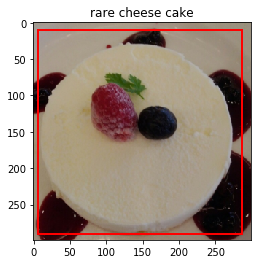

In [10]:
fig, axis= plt.subplots(1)

#randomly select image from dataset
i = np.random.randint(train_size)
img = train_raw[i][0].numpy()
img = np.transpose(img, (1,2,0))
img = img * 255
img = np.clip(img, 0, 1)
plt.imshow(img)

# draw bounding box
x1, y1, x2, y2 = train_raw[i][1]["boxes"][0]
box = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='r', facecolor='none')
axis.add_patch(box)

plt.title(class_names[train_raw[i][1]["labels"][0]])

fig

# Model

In order to train the food detector I will initially use transfer learning from a pretrained Faster R-CNN model on the COCO dataset.

In [11]:
print("Fetching pretrained model... ", end="")

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace classification head
num_classes = len(class_names)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

model = model.to(device)
print("done")

Fetching pretrained inception model...done


# Train

**Declare optimizer**

In [20]:
learning_rate = 0.01

# fetch trainable parameters for transfer learning(where requires_grad = true)
params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, lr=learning_rate)

**Train model**

In [21]:
num_epochs = 5

for epoch in range(5, 5+num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
    evaluate(model, val_loader, device)


AttributeError: 'InceptionOutputs' object has no attribute 'values'

**Save model**

In [ ]:
MODEL_PATH = os.path.join(ROOT_DIR, "models", "food_detection", "default_backbone.pt")

torch.save(model.state_dict(), MODEL_PATH)

# Evaluate